# Figure 4: ChromaFactor on Su et al. dataset

In [4]:
# General
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm_notebook
import csv
import sys
import math
import tqdm
from math import floor

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure
import seaborn as sns
from matplotlib import cm
import matplotlib as mpl

# scipy
from scipy.spatial import distance_matrix
from scipy.sparse import coo_matrix
import scipy.spatial.distance
from sklearn.model_selection import train_test_split


data_dir = "/srv/home/lgunsalus/data/fish/"
base_dir = "/srv/home/lgunsalus/"
data_dir = "/srv/home/lgunsalus/data/fish/"



In [22]:
import sys
sys.path.append('code')  

from DeepLearningChromatinStructure_code import *  # Rajpurkar et al. ORCA processing code 
from plot import *                                 # Plotting functions for 2D and 3D data
from utils import *                                # Util functions for 2D and 3D data
from ChromaFactor import *                         # ChromaFactor
from genomic_annotation import *                   # Genomic annotation functions
from fish_preprocessing import *                   # Genomic annotation functions

## Load dataset

In [6]:
chrom21 = pd.read_csv(data_dir + "chromosome21.tsv", sep="\t")
max_graph = max(chrom21['Chromosome copy number'])
min_graph = 1
idx_to_gene, gene_to_idx = return_gene_mapping(chrom21)

In [7]:
cur_gene = "HLCS"
cur_idx = gene_to_idx[cur_gene]
gene_no = cur_idx
cur_idx

27

## Establish window around gene 

In [8]:
cell_number = 1
resolution = 40000
total_window = 10000000
cellF = pull_chrom(cell_number, chrom21) 
cur_gene = idx_to_gene[gene_no]
label = gene_no
cur_gene

'HLCS'

## Gather positive and negative cells

In [11]:
positive_cells, negative_cells = get_cellids_by_transcription(max_graph,cur_idx,chrom21)

/srv/home/lgunsalus/anaconda3/envs/tf23/lib/python3.7/site-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/7590 [00:00<?, ?it/s]

In [12]:
# Get gene position
gene_pos = get_gene_pos(cellF, cur_gene)  
window_size = math.floor(total_window/2)

# number of positive and negative examples
print(len(positive_cells))
print(len(negative_cells))

positive_pull = positive_cells
negative_pull = negative_cells

1171
6419


# Build distance matrices around gene

In [13]:
positive_matrices = []
negative_matrices = []
failures = 0
for cell_number in tqdm_notebook(positive_pull):
    try:
        cellF = pull_chrom(cell_number, chrom21)                                 # Grab map for cell
        gene_pos = get_gene_pos(cellF, cur_gene)                                 # Get gene position
        start_loc, end_loc = gene_pos - window_size, gene_pos + window_size      # boundary start and stop locations 
        dummy = subset_by_window(cellF, start_loc, end_loc)
        distance_matrix = get_distance_matrix(dummy)

        positive_matrices.append(distance_matrix)
    except:
        failures += 1
print(failures)

failures = 0
for cell_number in tqdm_notebook(negative_pull):
    try:
        cellF = pull_chrom(cell_number, chrom21)                                 # Grab map for cell
        gene_pos = get_gene_pos(cellF, cur_gene)                                 # Get gene position
        start_loc, end_loc = gene_pos - window_size, gene_pos + window_size      # boundary start and stop locations 
        dummy = subset_by_window(cellF, start_loc, end_loc)
        distance_matrix = get_distance_matrix(dummy)

        negative_matrices.append(distance_matrix)
    except:
        failures += 1
print(failures)

/srv/home/lgunsalus/anaconda3/envs/tf23/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/1171 [00:00<?, ?it/s]

0


/srv/home/lgunsalus/anaconda3/envs/tf23/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/6419 [00:00<?, ?it/s]

0


# Plot maps

### Normalize maps and get median

In [14]:
# grab dummy
cellF = pull_chrom(cell_number, chrom21)     

# across all cells for one gene
gene_pos = get_gene_pos(cellF, cur_gene)                                 # Get gene position
window_size = math.floor(total_window/2)
start_loc, end_loc = gene_pos - window_size, gene_pos + window_size      # boundary start and stop locations 

# subset postive and negative 
dummy = subset_by_window(cellF, start_loc, end_loc)

positives = np.asarray(positive_matrices)
negatives = np.asarray(negative_matrices)

positive_median = np.nanmedian(positives, axis = 0)
negative_median = np.nanmedian(negatives, axis = 0)
sub_median =  positive_median - negative_median

normed_positive = distance_normalize_map(positive_median, dummy)
normed_negative = distance_normalize_map(negative_median, dummy)
sub_normed = normed_positive - normed_negative

contact_th = 500
positive_thresh = np.sum(positives<contact_th, axis=0) / np.sum(np.isnan(positives)==False, axis=0)
negative_thresh = np.sum(negatives<contact_th, axis=0) / np.sum(np.isnan(negatives)==False, axis=0)
sub_thresh = positive_thresh - negative_thresh

positive_normalized = normalize_map(positive_thresh,dummy)
negative_normalized = normalize_map(negative_thresh,dummy)
sub_normalized = positive_normalized - negative_normalized

## Plot positive median

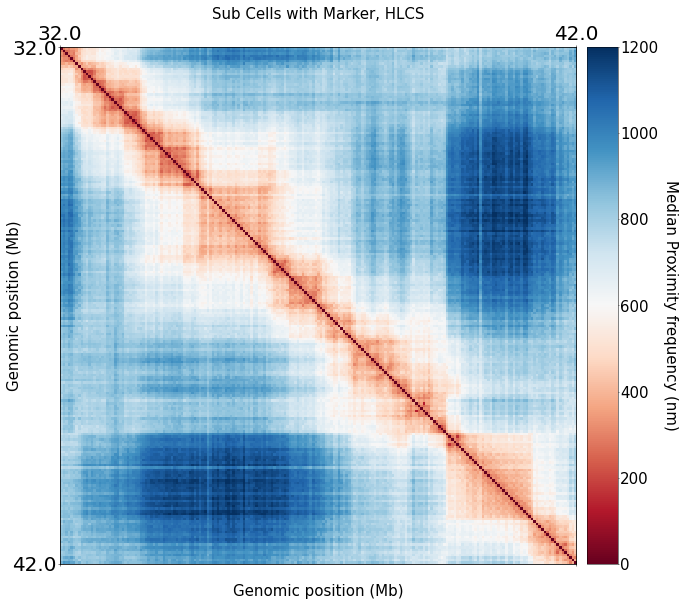

In [15]:
plot_distance_matrix(positive_median, cmap_order="forward", 
                     map_color = "green",
                     tick_positions = [start_loc, end_loc],
                     colorbar_labels='Median Proximity frequency (nm)',
                     midpoint_normalize=False,
                     vmax=1200,
                     title= "Sub Cells with Marker, " + cur_gene)

## Plot negative median

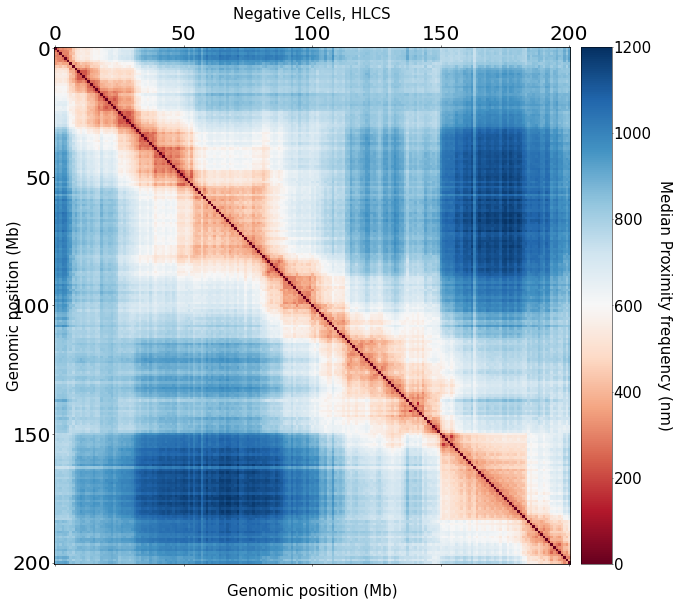

In [16]:
plot_distance_matrix(negative_median, cmap_order="forward", title= "Negative Cells, " + cur_gene, 
                                          colorbar_labels='Median Proximity frequency (nm)',
                                          vmax=1200,
                    )

### Plot difference between two maps

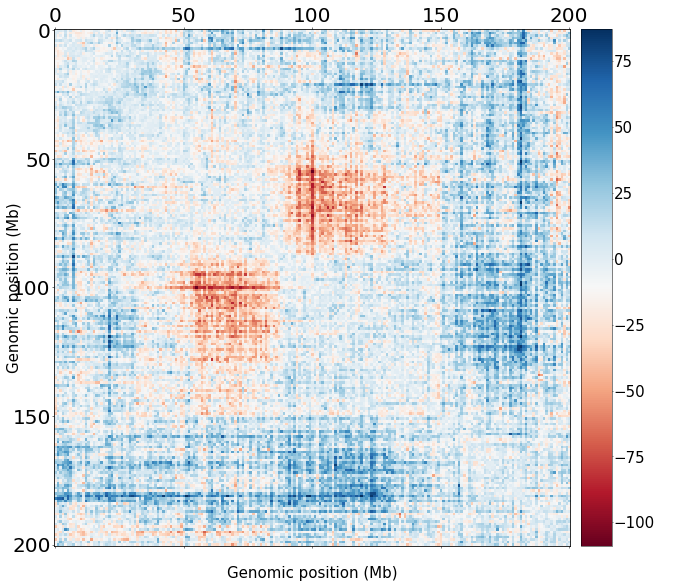

In [17]:
plot_distance_matrix(sub_median, cmap_order="forward", colorbar_labels=' ')

# Run ChromaFactor

In [20]:
reshaped_on = np.transpose(positives, (1, 2, 0))
reshaped_off = np.transpose(negatives, (1, 2, 0))
reshaped_maps = np.concatenate((reshaped_on, reshaped_off), axis=2)

# Create arrays of 1 and 0
ones_array = np.ones(reshaped_on.shape[2])
zeros_array = np.zeros(reshaped_off.shape[2])

# Concatenate the arrays
y = np.concatenate((ones_array, zeros_array))
reshaped_clean = np.nan_to_num(reshaped_maps)
no_components = 20

In [29]:
reshaped_array = reshaped_clean.transpose(2, 0, 1)

In [31]:
# Run ChromaFactor
chroma_factor = ChromaFactor(reshaped_array)

In [32]:
nmf_maps = chroma_factor.nmf_maps
components = chroma_factor.components
new_reshaped_maps = chroma_factor.reconstruct_maps()
error = chroma_factor.reconstruction_err

In [33]:
nmf_maps.shape

(201, 201, 20)

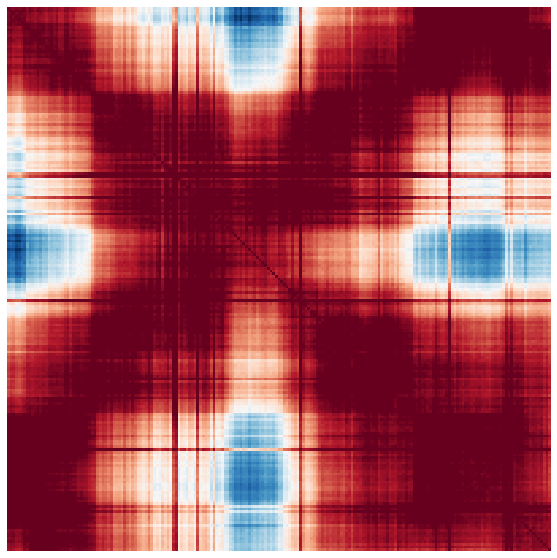

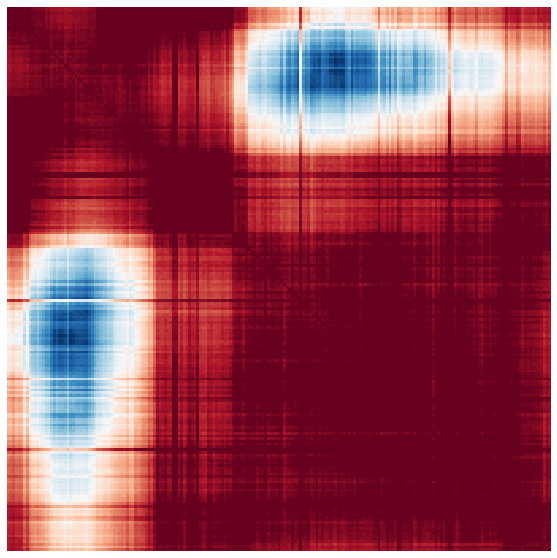

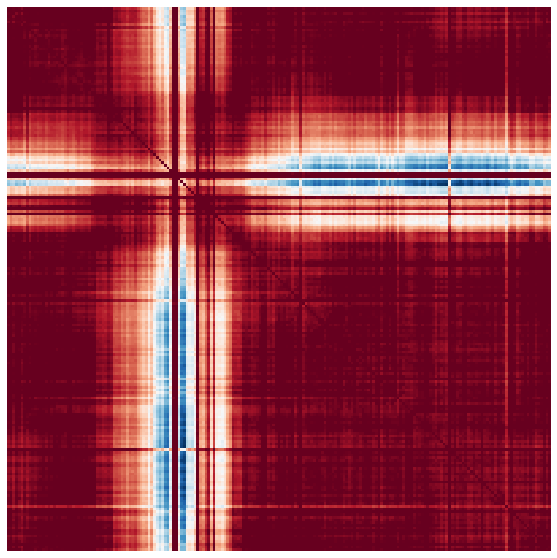

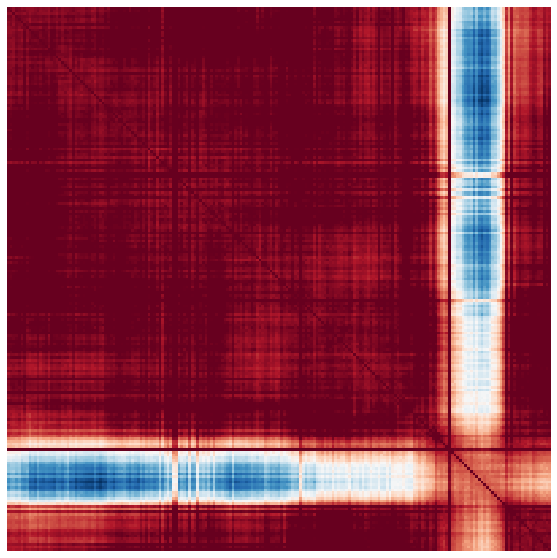

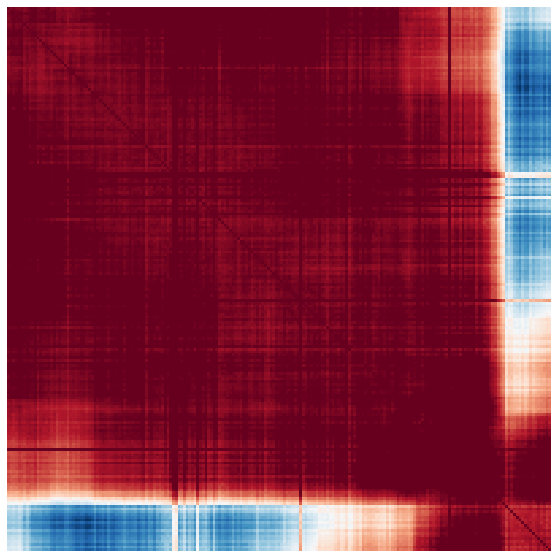

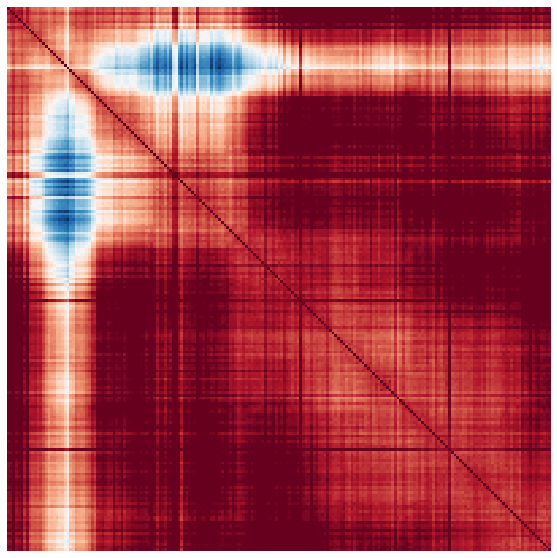

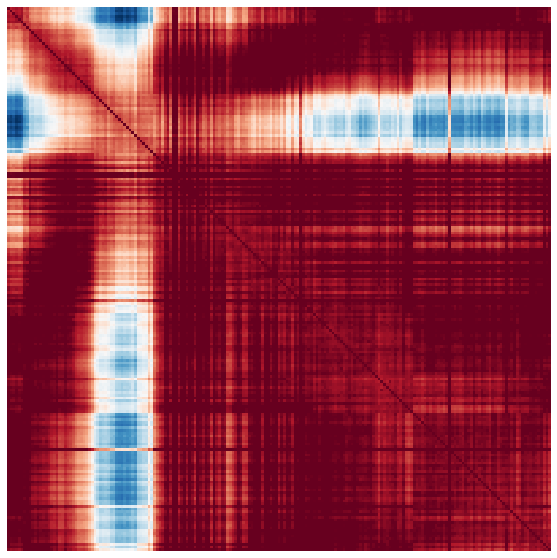

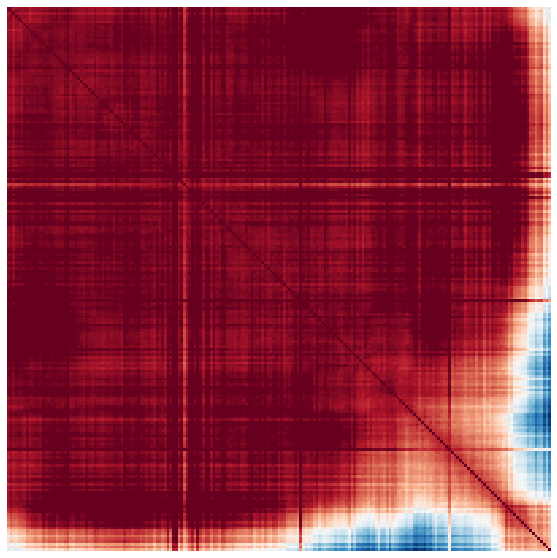

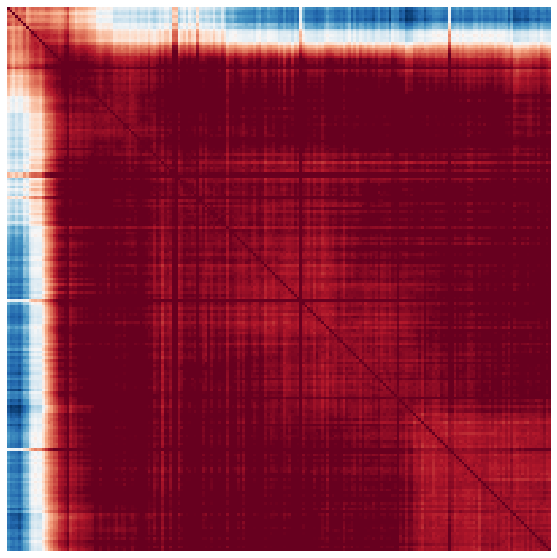

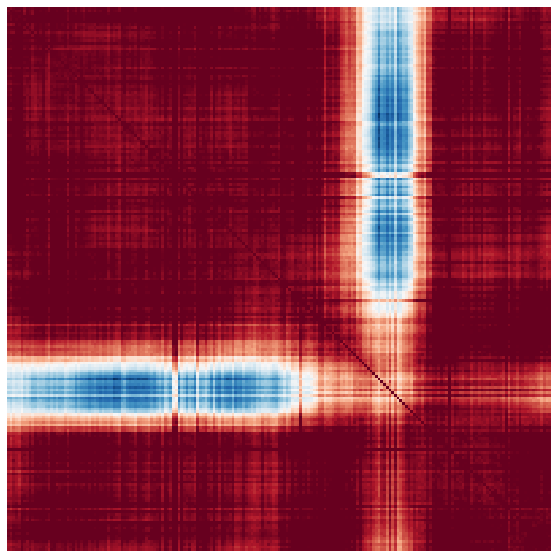

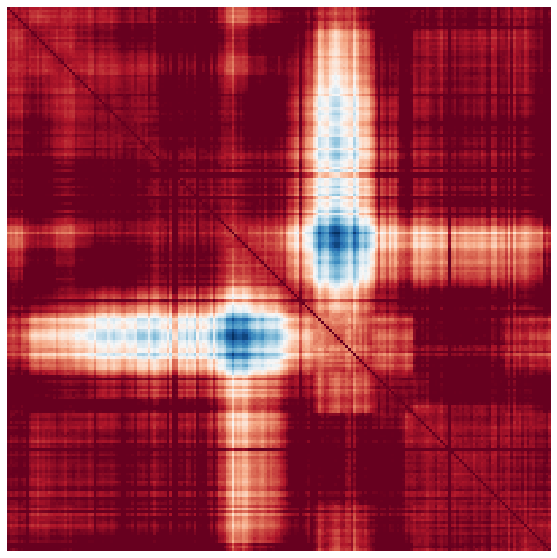

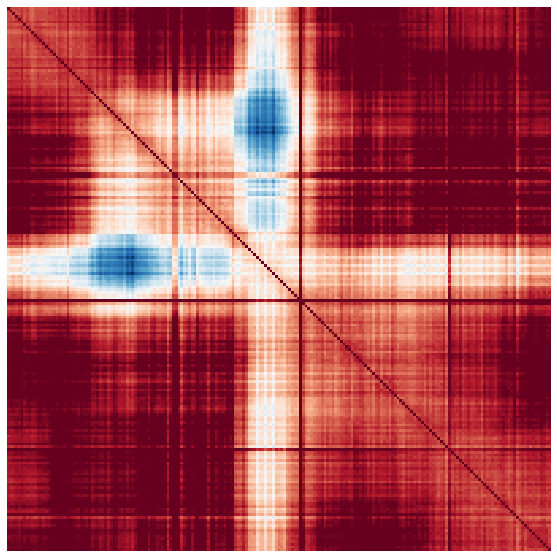

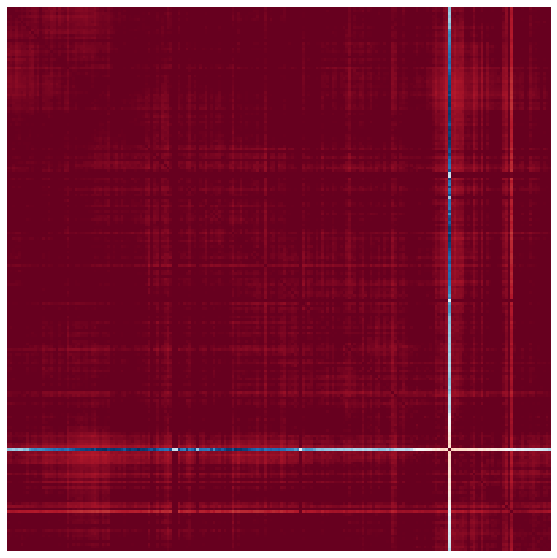

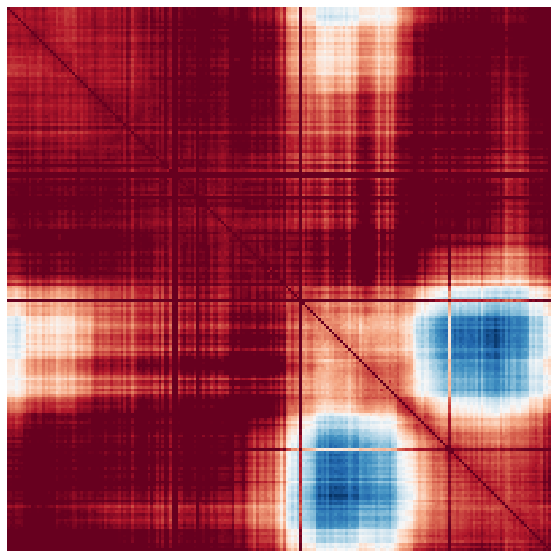

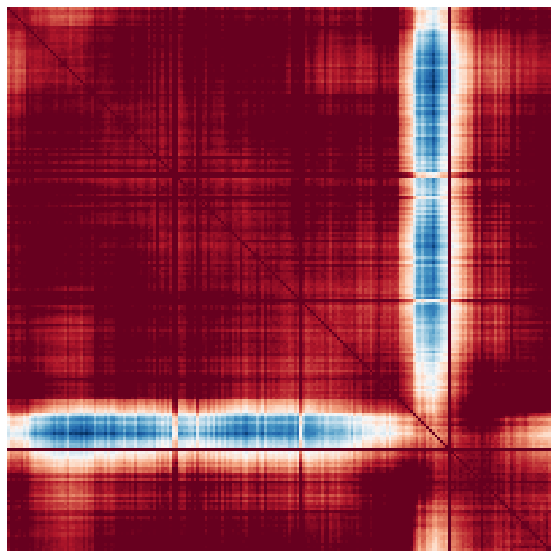

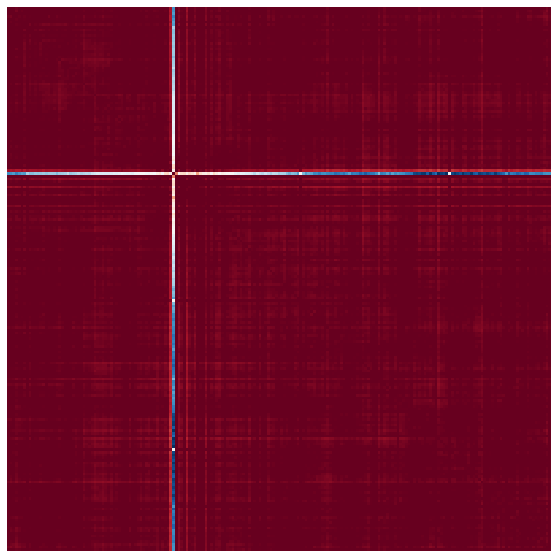

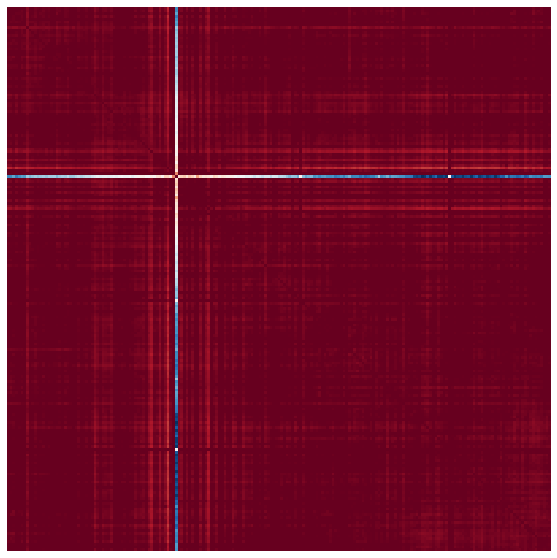

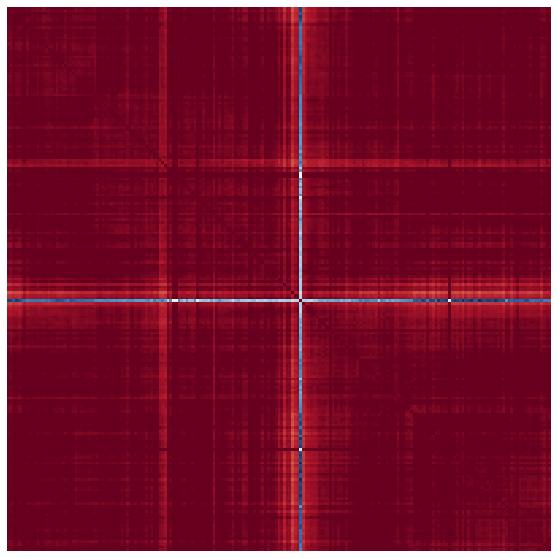

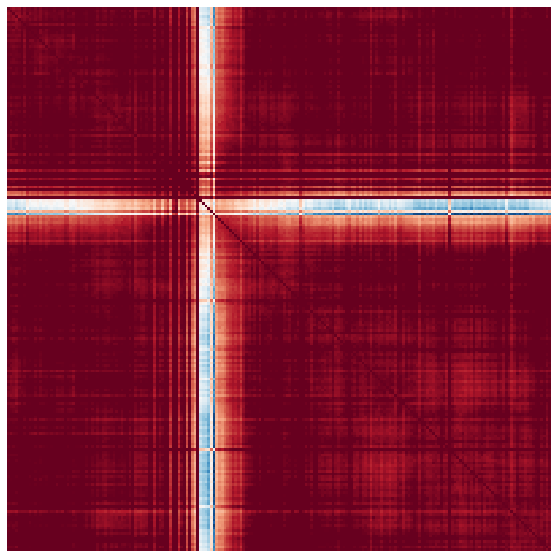

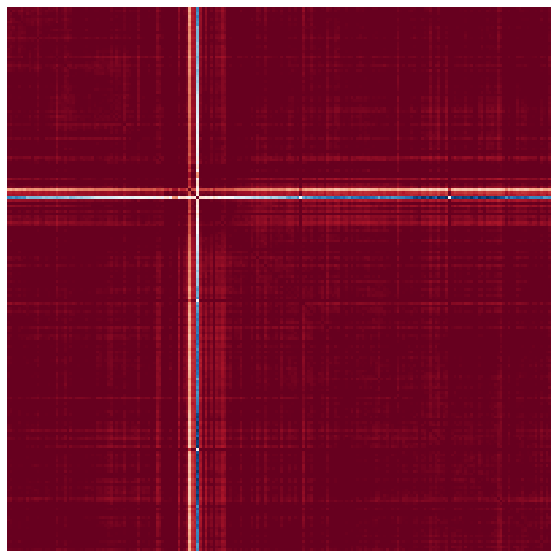

In [34]:
# Plot templates
chroma_factor.plot_nmf_maps()

# Component Significance

In [35]:
import scipy.stats as stats

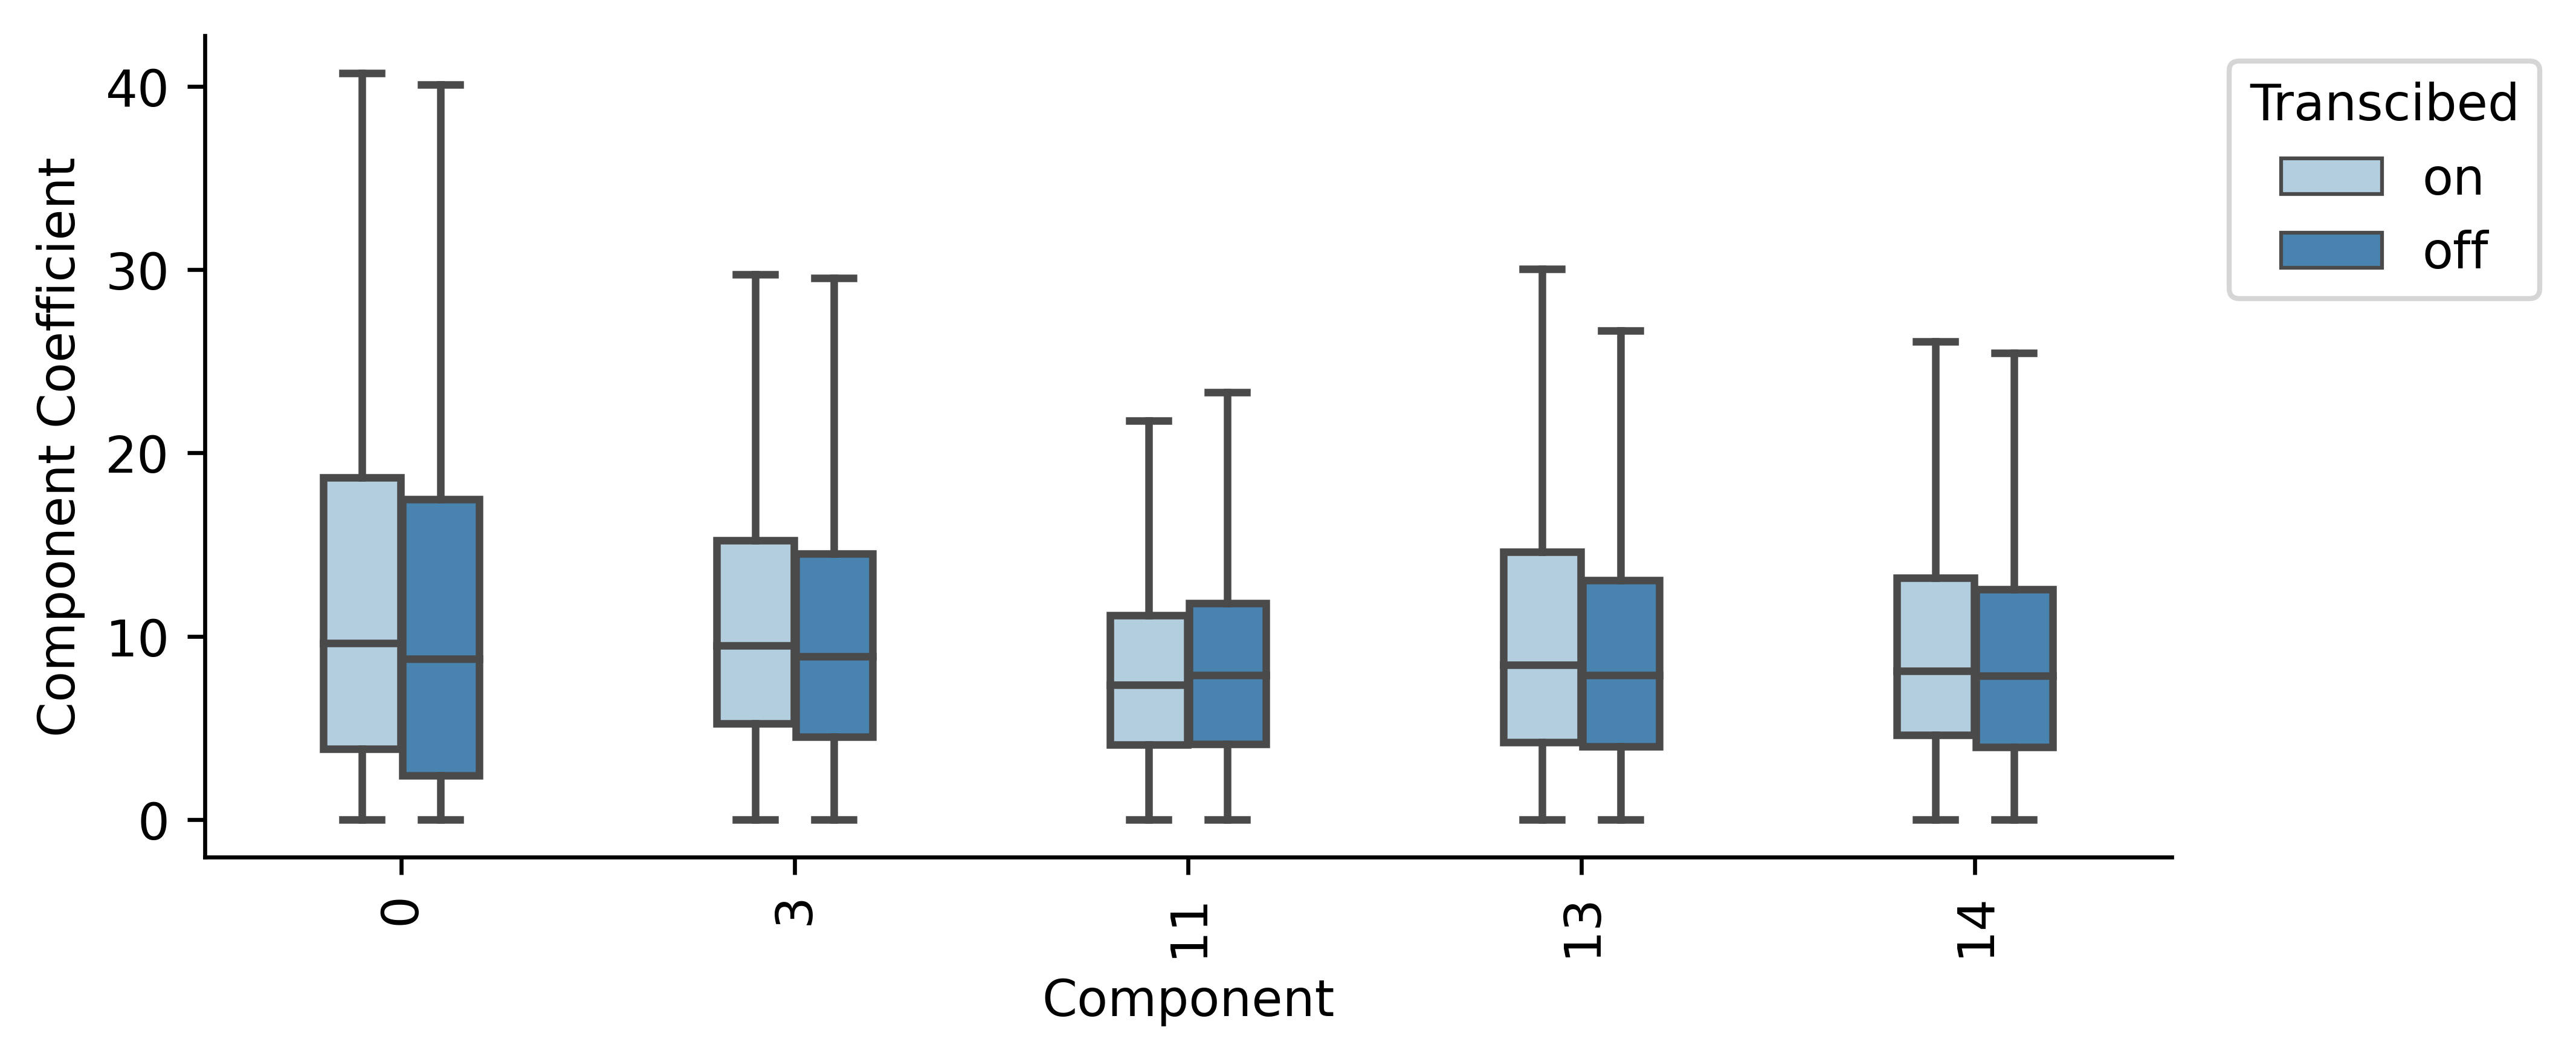

In [36]:
alpha =0.05 # significance cutoff

componentF = pd.DataFrame(components.T)
X = components

# List to hold significantly different components
significant_components = []
pvals = []

df = componentF
df["Cell_State"] = y


# List to hold significantly different components
significant_components = []
pvals = []

# Perform Manan-Whitney U test for each component
for component in df.columns[:-1]:  # Exclude the "Cell_State" column
    positive_values = df[df["Cell_State"] == 1][component]
    negative_values = df[df["Cell_State"] == 0][component]
    
    # Perform the test
    _, p_value = stats.mannwhitneyu(positive_values, negative_values, alternative='two-sided')

    # If the p-value is less than alpha, the difference is significant
    if p_value < alpha:
        significant_components.append(component)
        pvals.append(p_value)

# Filter the DataFrame to include only significant components
df_significant = df[significant_components + ["Cell_State"]]

# Convert DataFrame from wide to long format for easy plotting
df_melted = pd.melt(df_significant, id_vars="Cell_State", var_name="Component", value_name="Value")


df_melted['Cell_State'] = df_melted['Cell_State'].replace({0: 'off', 1: 'on'})

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

figure(figsize=(7,3), dpi=600)


ax = sns.boxplot(data=df_melted, x="Component", y="Value", hue="Cell_State", showfliers=False,
                 width=0.4,
             palette="Blues")
ax.legend(bbox_to_anchor= (1.2,1))


# Set the legend title
plt.gca().get_legend().set_title('Transcibed')

# Set the legend labels
plt.gcf().set_facecolor('none')

plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.ylabel('Component Coefficient')
plt.show()


# Prepare compartment

In [37]:
bedgraph_file = '/srv/home/lgunsalus/data/genome/reference/compartments/4DNFIHM89EGL.bedgraph' # IMR-90
compartmentF = pd.read_csv(bedgraph_file, sep='\t', header=None)
compartmentF.columns = ['chrom','start','end', 'score']

compartment_sub = compartmentF[compartmentF['chrom'] == 'chr21']
compartment_sub = compartment_sub[compartment_sub['start'] > 32000000]
compartment_sub = compartment_sub[compartment_sub['start'] < 42000000]

# Plot insulation tracks

In [39]:
from itertools import chain
from skimage.transform import rescale, resize, downscale_local_mean

In [42]:
insulation_0 = insulation_track(nmf_maps[...,0],)
insulation_3 = insulation_track(nmf_maps[...,3],)
insulation_11 = insulation_track(nmf_maps[...,11],)
insulation_13 = insulation_track(nmf_maps[...,13],)
insulation_14 = insulation_track(nmf_maps[...,14])

Text(0, 0.5, 'Compartment')

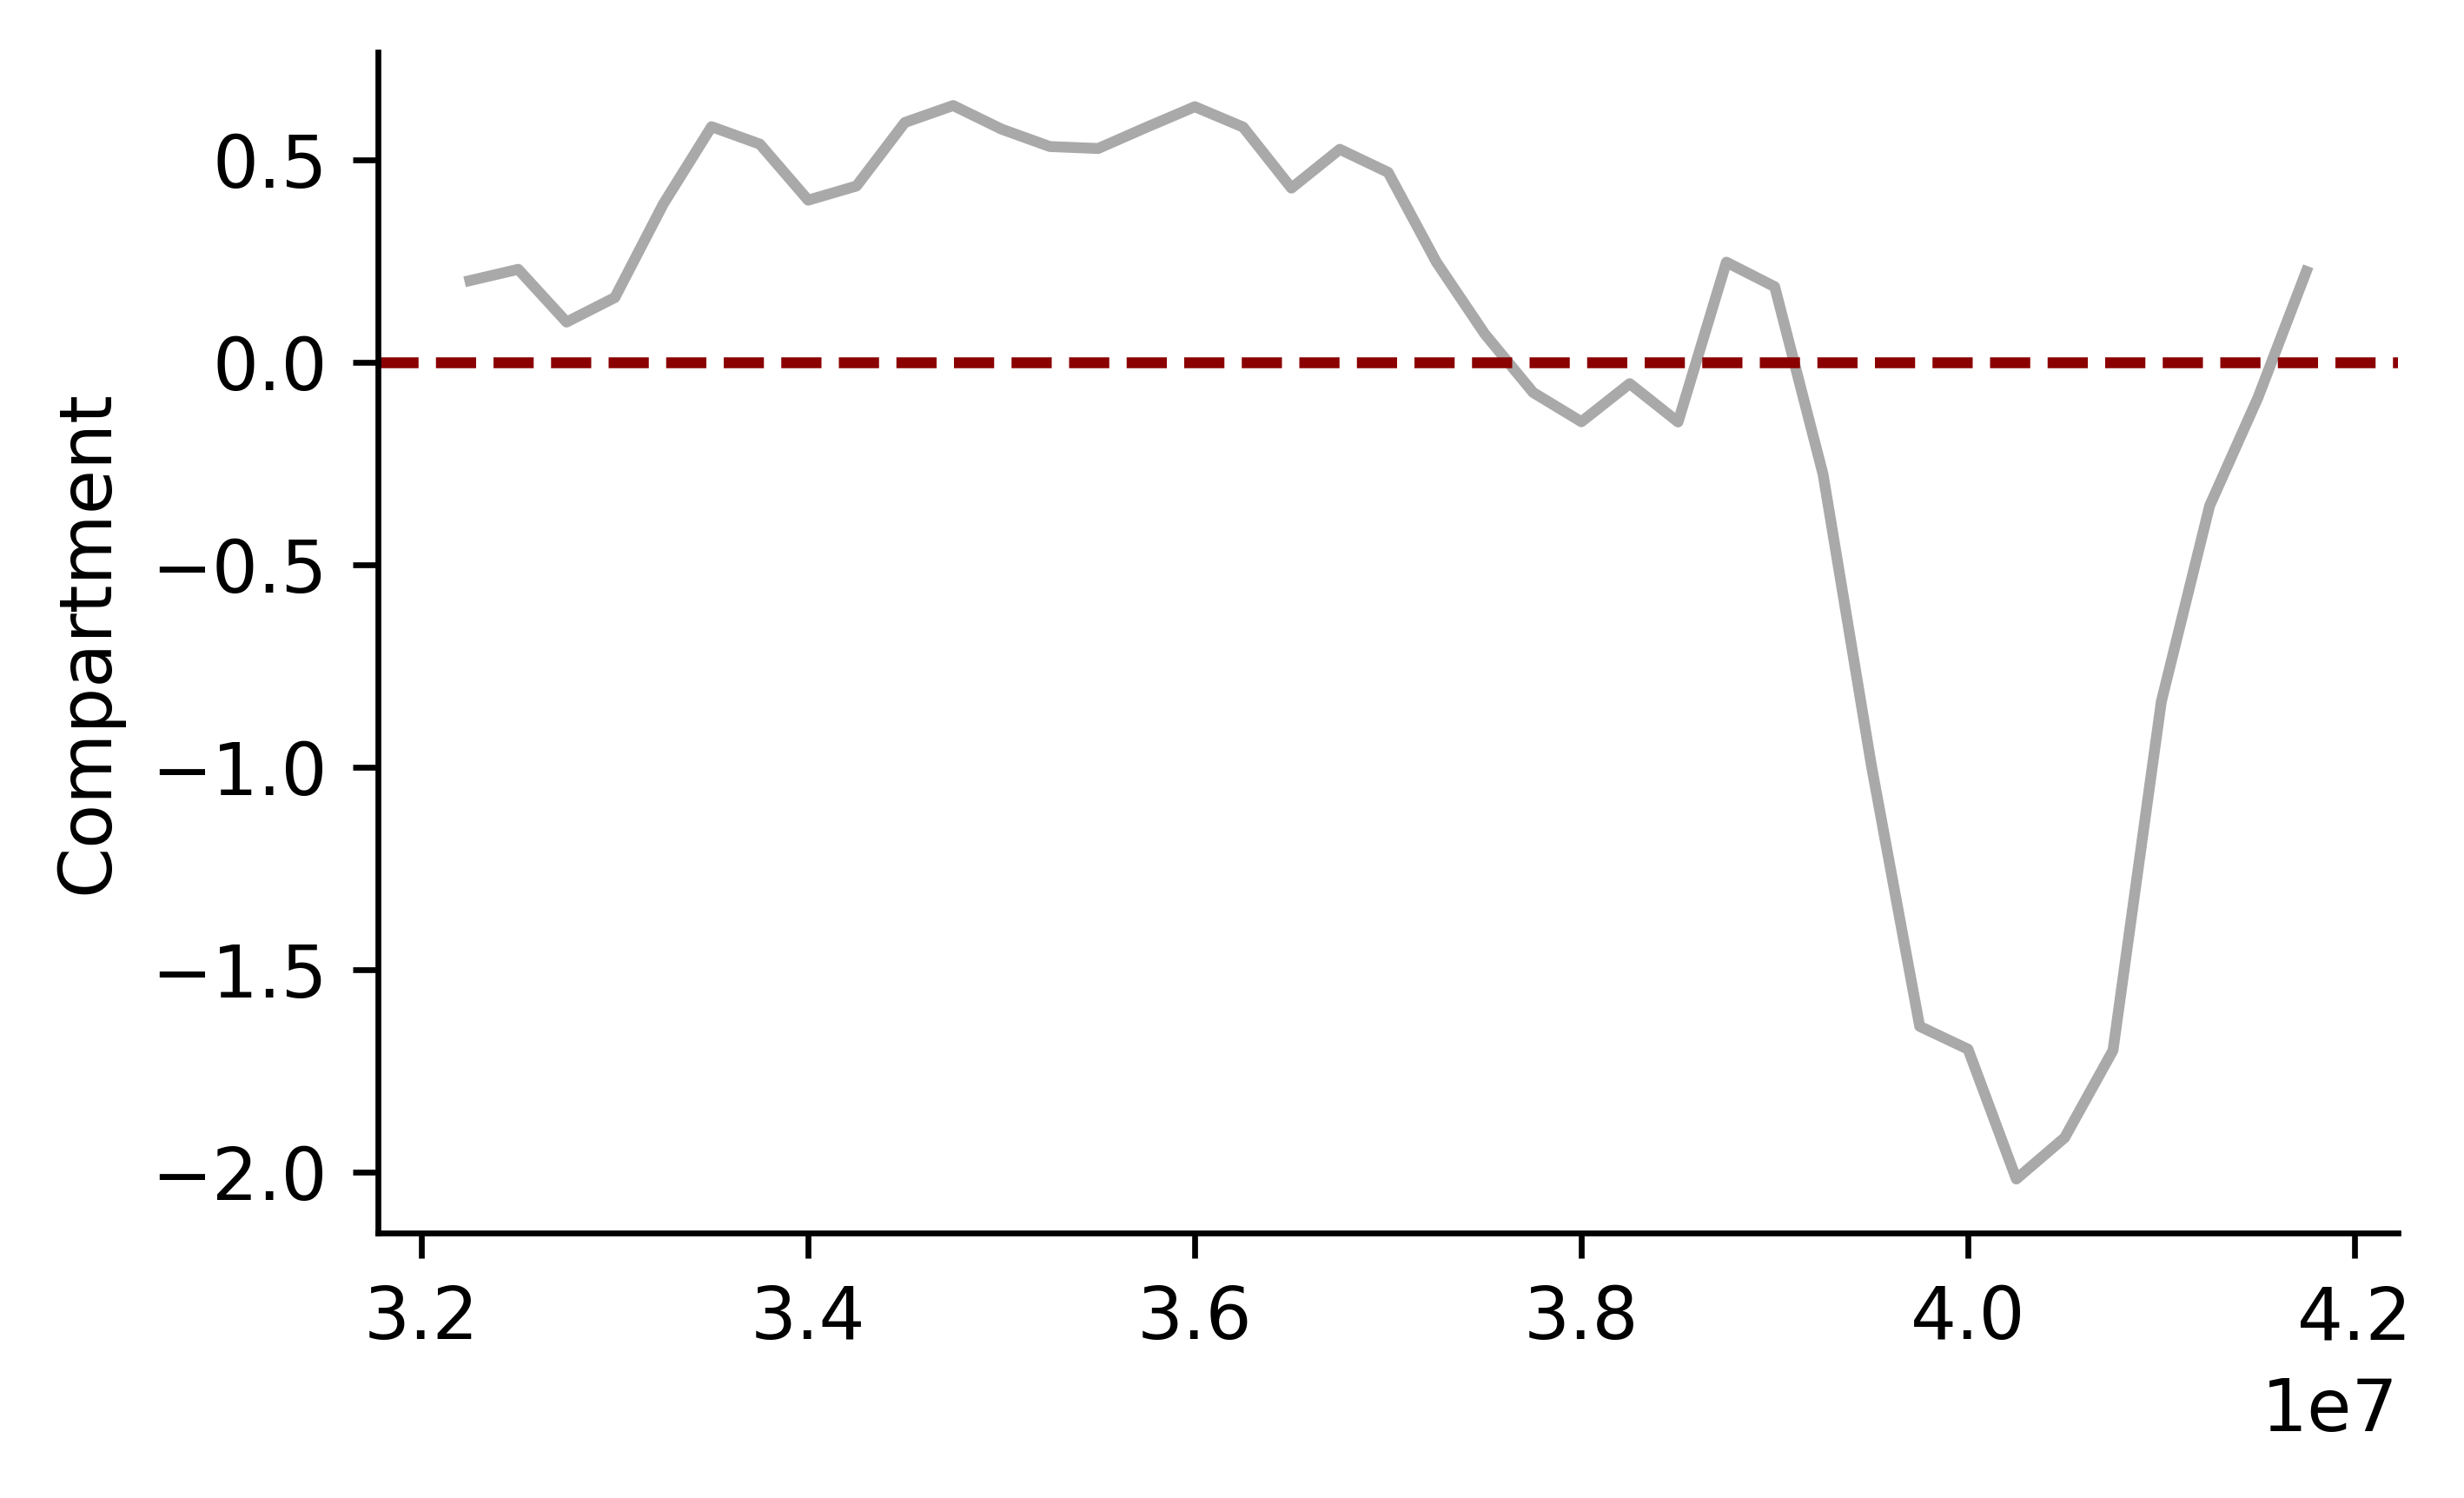

In [43]:
figure(figsize=(5,3), dpi=600)

plt.plot(compartment_sub['start'], compartment_sub['score'], color='darkgrey')
plt.axhline(y=0, color='darkred', linestyle='dashed')
plt.ylabel('Compartment')

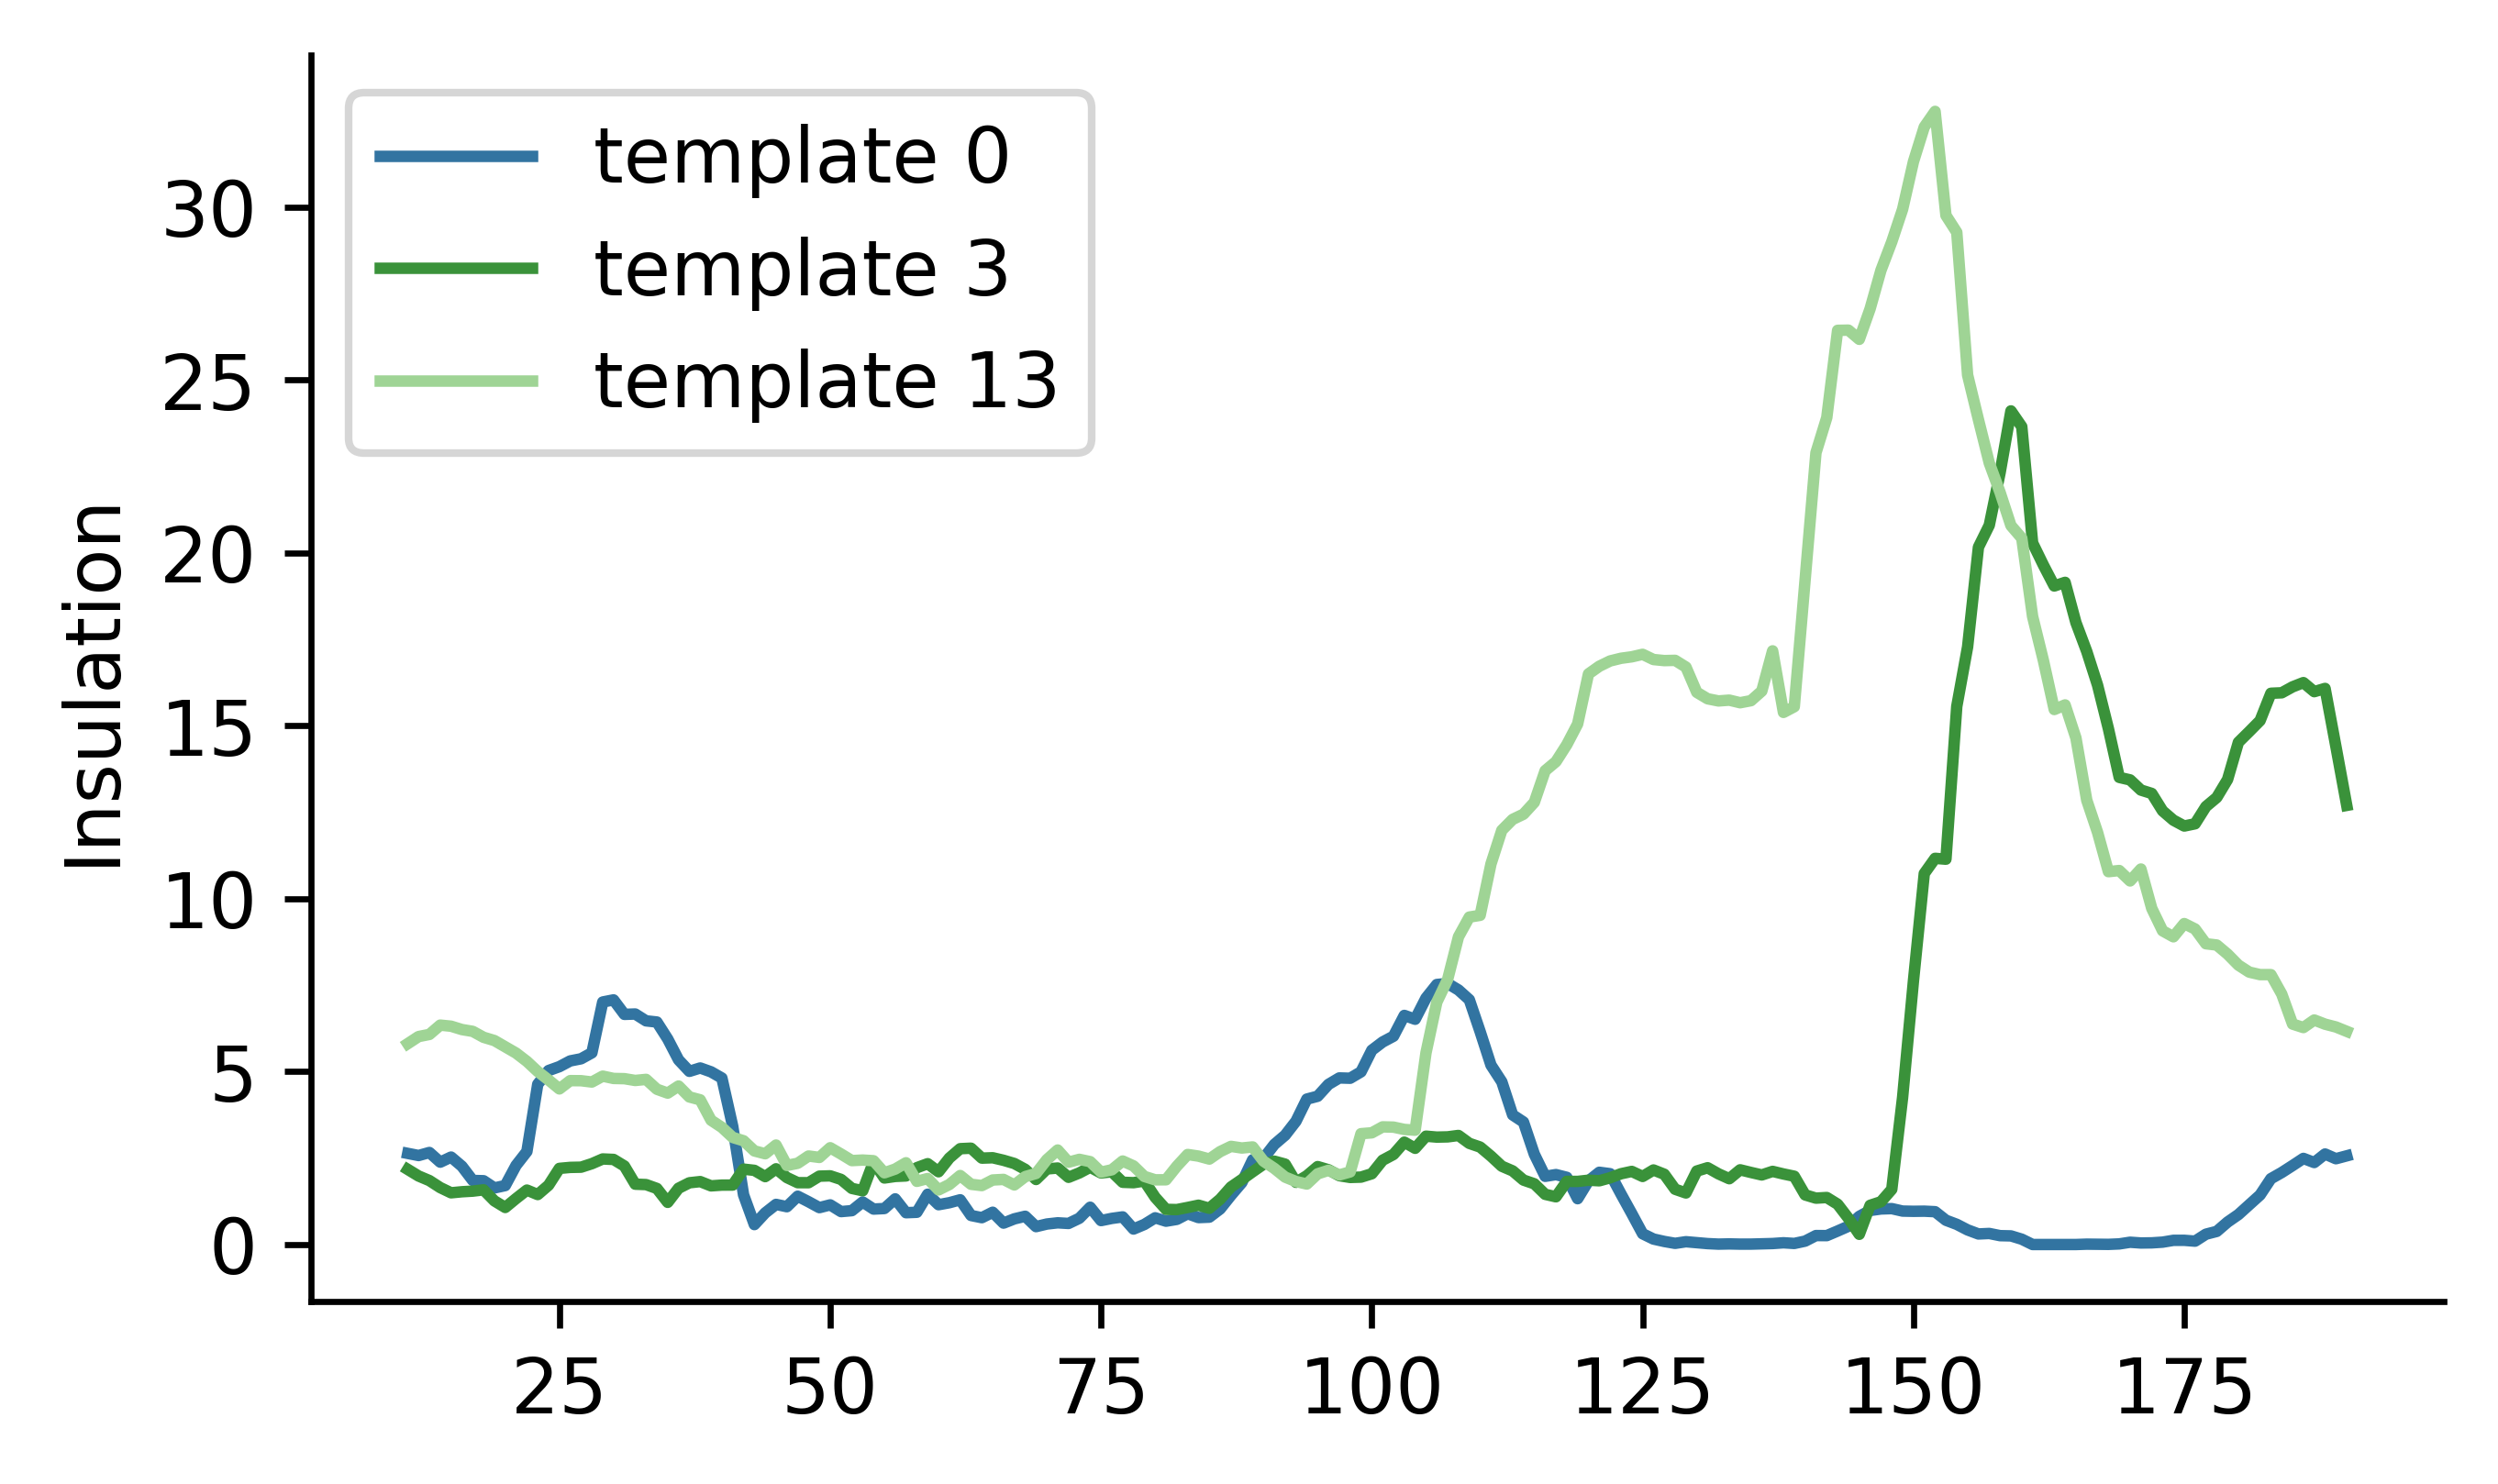

In [44]:
figure(figsize=(5,3), dpi=600)

plt.plot(insulation_0, label = 'template 0', color='#3274A1')
plt.plot(insulation_3, label='template 3', color='#3A923A')
plt.plot(insulation_13, label= 'template 13', color='#9FD495')

plt.ylabel('Insulation')
plt.legend()

## Directionality index

In [47]:
#input_mat = nmf_maps[...,3]
input_mat = nmf_maps[...,0]
# input_mat = nmf_maps[...,11]
# input_mat = nmf_maps[...,14]

new_resolution = 10000
downres_map = downres(input_mat, 10000)
input_map_size = 10000000
bp_per_pixels = np.around(input_map_size / new_resolution)
window_resolution = 10000
pixels_per_window = round(window_resolution / bp_per_pixels) 

summed_map = np.nansum(downres_map, axis=0) # contact summed across one axis
extended_map = np.concatenate([np.repeat(summed_map[0], pixels_per_window),
           summed_map,
          np.repeat(summed_map[0], pixels_per_window)]) # extend in window size each direction

replace_ends = True,
buffer = 50
pixels_per_window = int(pixels_per_window)
DI  = []
for i in range(int(pixels_per_window), summed_map.shape[0] + int(pixels_per_window)):
    A = extended_map[i - pixels_per_window:i].sum()
    B = extended_map[i:i+pixels_per_window].sum()
    E = (A + B) / 2

    sign = (B - A)/ abs(B - A)
    upstream = ((A - E)**2) / E
    downstream = ((B - E)**2) / E
    score = sign* (upstream + downstream)
    DI.append(score)
out = np.array([0] * buffer   + DI[buffer:len(DI) - buffer] + [0] * buffer)

In [ ]:
di_0 = DI
#di_11 = DI

In [45]:
figure(figsize=(5,3), dpi=600)
plt.plot(di_11, color='#B5C8E1', label='template 11')
plt.plot(di_0, color='#3274A1', label = 'template 0')
plt.ylabel('Directionality Index')
plt.legend()

NameError: name 'di_11' is not defined

<Figure size 3000x1800 with 0 Axes>